In [1]:
#from sam2.sam2_image_predictor import SAM2ImagePredictor
#print(dir(sam2))
from sam2.sam2_image_predictor import SAM2ImagePredictor
#from sam2.build_sam import build_sam2
#from sam2.sam2_image_predictor import SAM2ImagePredictor

#from transformers import Owlv2Processor, Owlv2ForObjectDetection
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
#import sys
from config import topview_vec, frontview_vec, vit_thresh, tower, realSenseFPS #, tcp_X_offset, tcp_Y_offset, tcp_Z_offset,
# sys.path.append("../")
import numpy as np
from magpie_control import realsense_wrapper as real
from magpie_control.ur5 import UR5_Interface as robot
from magpie_perception.label_owlv2 import LabelOWLv2
from Observation import observation_manager

import time
import os

#import random
from openai import OpenAI

from control_scripts import goto_vec, get_pictures, get_frames
from gpt_planning import get_gpt_next_instruction, print_json
from APIKeys import API_KEY


/home/user/sam2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2024-11-21 18:23:19.151633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 18:23:19.151661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 18:23:19.152633: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 18:23:19.158098: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 18:23:19.818357: W tensorflow/compiler/tf2

In [2]:
myrs = real.RealSense(fps=realSenseFPS)
myrs.initConnection()
myrobot = robot()
print(f"starting robot from nb")
myrobot.start()
label_vit = LabelOWLv2(topk=1, score_threshold=vit_thresh, cpu_override=False)
label_vit.model.eval()
#print(dir(label_vit.model))
print(f"{label_vit.model.device=}")

sam_predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")
print(f"{sam_predictor.model.device=}")

client = OpenAI(
        api_key= API_KEY,
    )


starting robot from nb
Found Dynamixel Port:
/dev/ttyACM1

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
label_vit.model.device=device(type='cuda', index=0)
sam_predictor.model.device=device(type='cuda', index=0)


In [3]:
myrobot.open_gripper()


Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [4]:
def topview_pick_place_Observations(observation_m, UR_Interface, pick_str, place_str):
    #print(place_str)
    #initlize local variables
    goto_vec(UR_Interface, topview_vec)
    observation_m.update_observations(display = False)
    pick_obs = observation_m.observations[pick_str]
    place_obs = observation_m.observations[place_str]
    return pick_obs, place_obs



In [5]:
def pick(UR_interface, obs):
    success = True
    goal_vec = obs.pickPose.copy()
    goal_vec[2] = topview_vec[2]
    goal_vec[3] = topview_vec[3]
    goal_vec[4] = topview_vec[4]
    goal_vec[5] = topview_vec[5]
    success = goto_vec(UR_interface, goal_vec)

    goal_vec[2] = obs.pickPose[2]
    success = goto_vec(UR_interface, goal_vec)

    UR_interface.close_gripper()
    time.sleep(2)

    goal_vec[2] = topview_vec[2]
    success = goto_vec(UR_interface, goal_vec)
    return success

#pick(myrobot, myrs, pick_bb, display = True)

In [6]:
def place(UR_interface, obs):

    success = True
    goal_vec = obs.placePose.copy()
    goal_vec[2] = topview_vec[2]
    goal_vec[3] = topview_vec[3]
    goal_vec[4] = topview_vec[4]
    goal_vec[5] = topview_vec[5]
    success = goto_vec(UR_interface, goal_vec)

    goal_vec[2] = obs.placePose[2]
    success = goto_vec(UR_interface, goal_vec)


    UR_interface.open_gripper()
    time.sleep(2)

    goal_vec[2] = topview_vec[2]
    success = goto_vec(UR_interface, goal_vec)

    return success


No LLM PLANNING

In [7]:
"""
#myrobot.stop()
#myrs.disconnect()
#tower = ["red block", "blue block", "green block", "yellow block", "purple block", "orange block"]
temp_tower = [ "yellow block", "blue block", "green block"]#, "green block"]
om = observation_manager(temp_tower, myrs, label_vit, sam_predictor, myrobot)
#tower = ["yellow block", "red block"]
for i in range(0, len(temp_tower)-1):
     pick_str = temp_tower[i+1]
     place_str = temp_tower[i]
     pick_obs, place_obs = topview_pick_place_Observations(om, myrobot, pick_str, place_str)
     pick(myrobot, pick_obs)
     place(myrobot, place_obs)
"""

'\n#myrobot.stop()\n#myrs.disconnect()\n#tower = ["red block", "blue block", "green block", "yellow block", "purple block", "orange block"]\ntemp_tower = [ "yellow block", "blue block", "green block"]#, "green block"]\nom = observation_manager(temp_tower, myrs, label_vit, sam_predictor, myrobot)\n#tower = ["yellow block", "red block"]\nfor i in range(0, len(temp_tower)-1):\n     pick_str = temp_tower[i+1]\n     place_str = temp_tower[i]\n     pick_obs, place_obs = topview_pick_place_Observations(om, myrobot, pick_str, place_str)\n     pick(myrobot, pick_obs)\n     place(myrobot, place_obs)\n'

YES LLM PLANNING

In [8]:
def create_next_directory(base_dir):
    # List all subdirectories in the base directory
    subdirectories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    # Extract the numeric part of the directory names (e.g., 'run_0', 'run_1')
    subdirectories = [d for d in subdirectories if d.startswith('run_')]
    subdirectories = [int(d.split('_')[1]) for d in subdirectories if d.split('_')[1].isdigit()]
    
    # If there are no subdirectories, start from 0, else find the max and add 1
    next_dir = max(subdirectories, default=-1) + 1

    # Create the new directory with the name 'run_<next_dir>'
    next_dir_path = os.path.join(base_dir, f"run_{next_dir}")
    os.makedirs(next_dir_path, exist_ok=True)
    
    return next_dir_path

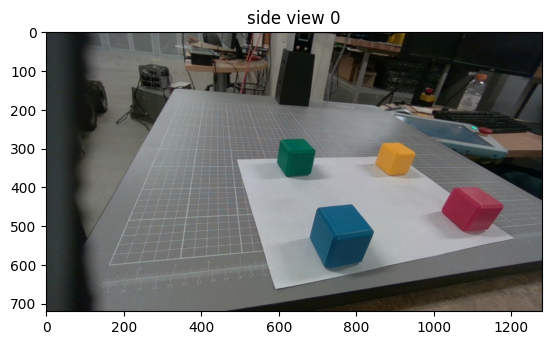

state['objects']=['table', 'white paper', 'green block', 'yellow block', 'blue block', 'red block']
state={
    "objects": [
        "table",
        "white paper",
        "green block",
        "yellow block",
        "blue block",
        "red block"
    ],
    "object_relationships": [
        [
            "white paper",
            "table"
        ],
        [
            "green block",
            "white paper"
        ],
        [
            "yellow block",
            "white paper"
        ],
        [
            "blue block",
            "white paper"
        ],
        [
            "red block",
            "white paper"
        ]
    ]
}
next instruction={
    "current state": "All blocks are on the white paper: green, yellow, blue, red.",
    "done": false,
    "explanation": "To start building the desired tower, we need the dark blue block at the base. Currently, the blue block is on the white paper, which is correct for the base position.",
    "pick": "blue block",
  

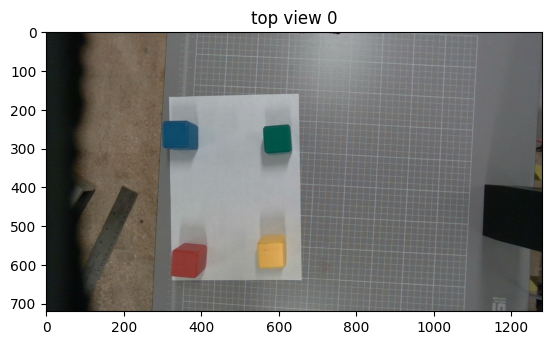

self.observation_pose=[-0.16186994864085663, -0.6234373546060831, 0.42745891478640125, 2.2214696445151216, -2.2214132919727736, 3.341250929805919e-05]
Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to 450 
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


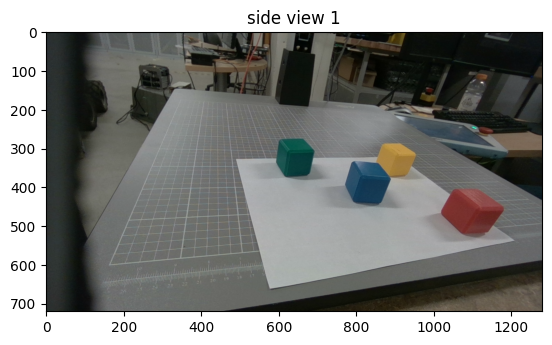

state['objects']=['table', 'white paper', 'green block', 'blue block', 'yellow block', 'red block']
state={
    "objects": [
        "table",
        "white paper",
        "green block",
        "blue block",
        "yellow block",
        "red block"
    ],
    "object_relationships": [
        [
            "white paper",
            "table"
        ],
        [
            "green block",
            "white paper"
        ],
        [
            "blue block",
            "white paper"
        ],
        [
            "yellow block",
            "white paper"
        ],
        [
            "red block",
            "white paper"
        ]
    ]
}
next instruction={
    "current state": "The blue block is at the base of the tower on the white paper.",
    "done": false,
    "explanation": "Next, we need to place the green block on top of the blue block to continue building the tower in the correct order.",
    "pick": "green block",
    "place": "blue block",
    "end state": "The 

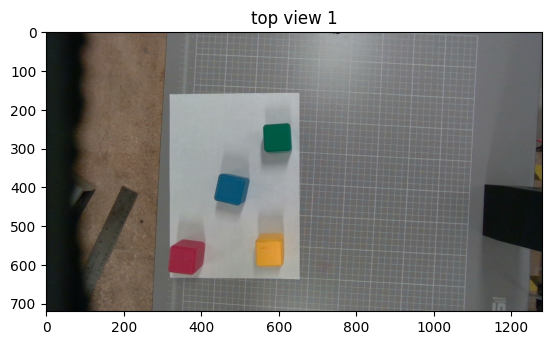

self.observation_pose=[-0.16187618662543354, -0.6234200759412323, 0.4274901981076105, -2.2213628511258987, 2.2215200830083526, -7.072812538793188e-05]
Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to 450 
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


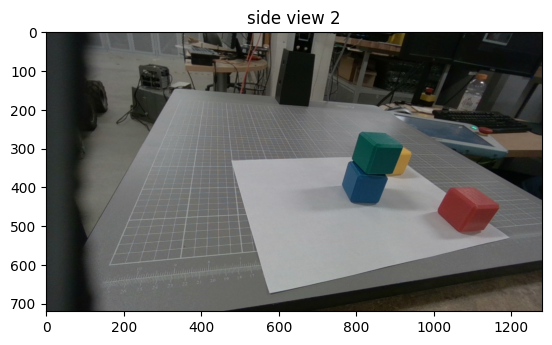

state['objects']=['table', 'white paper', 'green block', 'blue block', 'yellow block', 'red block']
state={
    "objects": [
        "table",
        "white paper",
        "green block",
        "blue block",
        "yellow block",
        "red block"
    ],
    "object_relationships": [
        [
            "green block",
            "blue block"
        ],
        [
            "blue block",
            "white paper"
        ],
        [
            "yellow block",
            "white paper"
        ],
        [
            "red block",
            "white paper"
        ],
        [
            "white paper",
            "table"
        ]
    ]
}
next instruction={
    "current state": "The green block is on top of the blue block.",
    "done": false,
    "explanation": "Now, we need to place the yellow block on top of the green block to continue the sequence.",
    "pick": "yellow block",
    "place": "green block",
    "end state": "The yellow block is now on top of the green blo

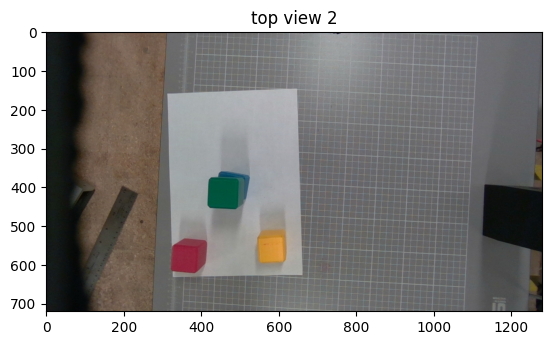

self.observation_pose=[-0.16185601474172445, -0.6234248872791142, 0.4274901985976579, -2.2214292013501167, 2.221453736045039, -5.320061924786508e-05]
Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to 450 
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


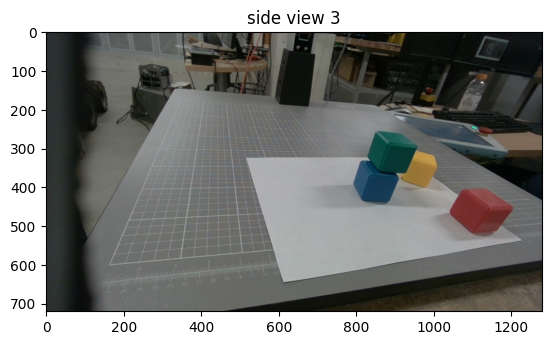

state['objects']=['table', 'white paper', 'green block', 'blue block', 'yellow block', 'red block']
state={
    "objects": [
        "table",
        "white paper",
        "green block",
        "blue block",
        "yellow block",
        "red block"
    ],
    "object_relationships": [
        [
            "green block",
            "blue block"
        ],
        [
            "blue block",
            "white paper"
        ],
        [
            "yellow block",
            "white paper"
        ],
        [
            "red block",
            "white paper"
        ],
        [
            "white paper",
            "table"
        ]
    ]
}
next instruction={
    "current state": "The yellow block is on top of the green block.",
    "done": false,
    "explanation": "Finally, place the red block on top of the yellow block to complete the tower.",
    "pick": "red block",
    "place": "yellow block",
    "end state": "The red block is now on top of the yellow block, completing

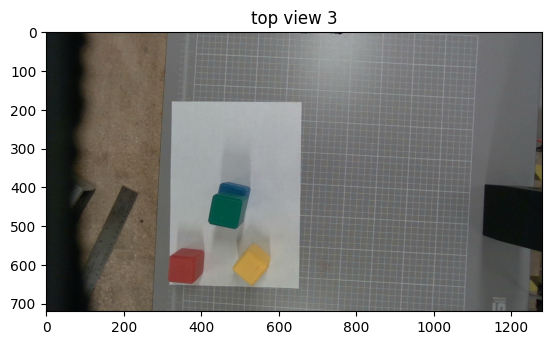

self.observation_pose=[-0.1618679056465807, -0.6234260098246286, 0.427526336471271, 2.221358455885471, -2.22140812805469, 0.00014781306758468348]
Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to 450 
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


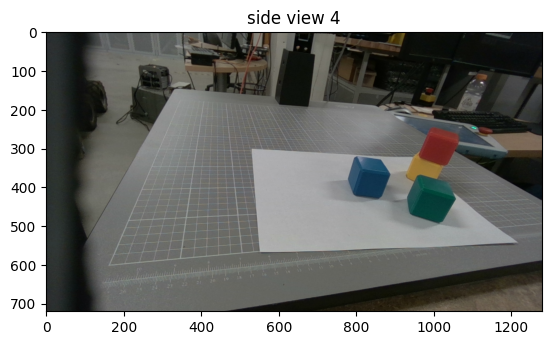

state['objects']=['table', 'white paper', 'blue block', 'green block', 'yellow block', 'red block']
state={
    "objects": [
        "table",
        "white paper",
        "blue block",
        "green block",
        "yellow block",
        "red block"
    ],
    "object_relationships": [
        [
            "white paper",
            "table"
        ],
        [
            "blue block",
            "white paper"
        ],
        [
            "green block",
            "white paper"
        ],
        [
            "yellow block",
            "white paper"
        ],
        [
            "red block",
            "yellow block"
        ]
    ]
}
next instruction={
    "current state": "The red block is on top of the yellow block, which is on top of the green block, which is on top of the blue block.",
    "done": true,
    "explanation": "The tower is now correctly configured with the dark blue block at the base, followed by the green, yellow, and red blocks.",
    "pick": "",
 

In [9]:

#tower = ["red block", "blue block", "green block", "yellow block", "purple block"]
#tower = tower.reverse()
n_attempts = 2*len(tower)
Done = 0
i = 0
top_dir = "./data_collection/"
os.makedirs(top_dir, exist_ok=True)
save_dir = create_next_directory(top_dir)
action_history = []
previous_plan = []
while(not Done and i < n_attempts):
    interation_output_dir = os.path.join(save_dir, f"step {i}")
    os.makedirs(interation_output_dir, exist_ok=True)
    goto_vec(myrobot, frontview_vec)
    rgb_img, depth_img = get_pictures(myrs)
    plt.imshow(rgb_img)
    plt.title(f"side view {i}")
    plt.show()
    plt.imsave(os.path.join(interation_output_dir, "sideview.png"), rgb_img)

    (state_resp, state, state_sys_prompt, state_usr_promot), (instruction_resp, next_instruction, future_instructions, instruction_sys_prompt, instruction_usr_prompt) = get_gpt_next_instruction(client, rgb_img, tower, action_history, previous_plan)
    print(f"{state['objects']=}")
    om = observation_manager(state["objects"], myrs, label_vit, sam_predictor, myrobot)
    with open(os.path.join(interation_output_dir, "instruction.txt"), "w") as file:
        state_str = print_json(state, name="state")
        file.write(f"{state_str}\n")

        next_instruction_str = print_json(next_instruction, "next instruction")
        file.write(f"{next_instruction_str}")


        instruction_plan_str = print_json(future_instructions, name="plan")
        file.write(f"{instruction_plan_str}")

        file.write(f"{state_sys_prompt=}\n")
        file.write(f"{state_usr_promot=}\n")
        file.write(f"{instruction_sys_prompt=}\n")
        file.write(f"{instruction_usr_prompt=}\n")
        print(f"{instruction_usr_prompt=}")
    
    action_history.append(next_instruction)
    previous_plan = future_instructions
    Done = int(next_instruction["done"])
    
   

    if Done:
        break
    pick_str= next_instruction['pick']
    place_str= next_instruction['place']
    goto_vec(myrobot, topview_vec)
    rgb_img, depth_img = get_pictures(myrs)
    plt.imshow(rgb_img)
    plt.title(f"top view {i}")
    plt.show()
    plt.imsave(os.path.join(interation_output_dir, "topview.png"), rgb_img)
    pick_obs, place_obs = topview_pick_place_Observations(om, myrobot, pick_str, place_str)
    pick(myrobot, pick_obs)
    place(myrobot, place_obs)
    i += 1
